In [2]:
# !pip install spacy
# !pip install transformers datasets
# !pip install scikit-learn
# !pip install numpy requests nlpaug sentencepiece

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

import nlpaug.augmenter.word as naw

import time
from tqdm import tqdm
import random

In [2]:
SEED = 42
random.seed(SEED)           # Python random
np.random.seed(SEED)        # NumPy random
torch.manual_seed(SEED)     # PyTorch CPU
torch.cuda.manual_seed_all(SEED)  # PyTorch GPU (if used)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def create_df(data_file):
    with open(data_file, 'r') as file:
        text_list = []
        label_list = []
        for line in file:
            result = line.strip().split(':')
            label_list.append(result[0])
            text_list_ = result[1].split()
            text_list.append(' '.join(text_list_[1:]))

    data = {
        "text": text_list,
        "label": label_list
    }

    return pd.DataFrame(data)

train_path = 'C:/Users/yauju/Documents/DS notebook/nlp_project/data/train_5500.txt'
train_df = create_df(train_path)
test_df = create_df(r'C:/Users/yauju/Documents/DS notebook/nlp_project/data/TREC_10.txt')
        

In [35]:
train_df

,text,label
0,How did serfdom develop in and then leave Russ...,DESC
1,What films featured the character Popeye Doyle ?,ENTY
2,How can I find a list of celebrities ' real na...,DESC
3,What fowl grabs the spotlight after the Chines...,ENTY
4,What is the full form of .com ?,ABBR
...,...,...
5447,What 's the shape of a camel 's spine ?,ENTY
5448,What type of currency is used in China ?,ENTY
5449,What is the temperature today ?,NUM
5450,What is the temperature for cooking ?,NUM


In [34]:
train_df.duplicated().sum()

np.int64(75)

In [5]:
train_df.drop_duplicates(inplace=True)

In [6]:
possible_labels = train_df.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'DESC': 0, 'ENTY': 1, 'ABBR': 2, 'HUM': 3, 'NUM': 4, 'LOC': 5}

In [7]:
train_df['label'] = train_df.label.replace(label_dict)
test_df['label'] = test_df.label.replace(label_dict)

C:\Users\yauju\AppData\Local\Temp\ipykernel_1552\3578331454.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['label'] = train_df.label.replace(label_dict)
C:\Users\yauju\AppData\Local\Temp\ipykernel_1552\3578331454.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['label'] = test_df.label.replace(label_dict)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state=42)
X_test, y_test = test_df['text'], test_df['label']

In [127]:
aug_list = [
    naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert", aug_p=0.1),
    naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute", aug_p=0.1)
]

def augment_text(X_train, y_train, p_aug=0.3):
    new_text=[]
    new_label = []
    counter = 0
    ## data augmentation loop   
    for text, label in tqdm(zip(X_train, y_train), total=len(X_train)):
        augmented = False
        for aug in aug_list:
            if random.random() < p_aug:
                text = aug.augment(text)
                augmented = True
                
        if  augmented:
            counter += 1
            if isinstance(text, list):
                text = text[0]
            new_text.append(text)
            new_label.append(label)

    ## dataframe
    X_train.extend(new_text)
    y_train.extend(new_label)
    
    df=pd.DataFrame({'text':X_train, 'label':y_train}).sample(frac=1).reset_index(drop=True)

    return df['text'], df['label'], counter
    
# X_train, y_train, augmented_count = augment_text(X_train.tolist(),y_train.tolist(), 0.3)

100%|██████████████████████████████████████████████████████████████████████████████| 4301/4301 [02:45<00:00, 26.04it/s]


In [128]:
# print("augmented data: ", augmented_count)

augmented data:  2188


In [9]:
class TRECDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
MAX_LEN = 50
BATCH_SIZE = 32

train_dataset = TRECDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = TRECDataset(X_val, y_val, tokenizer, MAX_LEN)
test_dataset = TRECDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [11]:
# BertConfig, increase dropout prob
config = BertConfig.from_pretrained('bert-base-uncased',
                                    num_labels=6,
                                    hidden_dropout_prob=0.3,
                                    attention_probs_dropout_prob=0.3)


# # Create model with modified config
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

model = model.to(device)

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def train_epoch(model, data_loader, val_loader, optimizer, device, step_count=0):
    train_acc_list = []
    model.train()
    running_loss = 0
    correct_predictions = 0
    total_samples_seen = 0
    
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        running_loss += loss.item()
        total_samples_seen += labels.size(0)
        if step_count%10 == 0 and step_count != 0:
            avg_loss = running_loss / 10
            training_losses.append(avg_loss)
            running_loss = 0.0
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        step_count += 1
        
        if step_count%100 == 0:
            train_acc = correct_predictions.double() / total_samples_seen
            train_acc_list.append(train_acc)
            correct_predictions = 0
            val_acc = evaluate_model(model, val_loader, device)
            val_accuracies.append(val_acc)
            total_samples_seen = 0
            model.train()
    
    return train_acc_list, step_count


# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_loss += loss.item()

    return correct_predictions.double() / len(data_loader.dataset)

In [13]:
training_losses = []
train_accuracies = []
val_accuracies = []

EPOCHS = 5
step_count = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    train_acc, step_count = train_epoch(model, train_loader, val_loader, optimizer, device, step_count)
    train_accuracies.extend(train_acc)
    print(f'time taken: {time.time()-start_time}')

Epoch 1/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [01:05<00:00,  2.06it/s]


time taken: 65.56926798820496
Epoch 2/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [01:05<00:00,  2.06it/s]


time taken: 65.5031886100769
Epoch 3/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [01:12<00:00,  1.86it/s]


time taken: 72.64538764953613
Epoch 4/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [01:08<00:00,  1.97it/s]


time taken: 68.62231421470642
Epoch 5/5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [01:09<00:00,  1.95it/s]

time taken: 69.2825722694397


In [14]:
def print_fig():
    epochs = [i for i in range(EPOCHS)]
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    train_accs_list = []
    for tensor in train_accuracies:
        train_accs_list.append(tensor.cpu().numpy().item())
        
    val_accs_list = []
    for tensor in val_accuracies:
        val_accs_list.append(tensor.cpu().numpy().item())
        
    ax[0].plot(range(len(training_losses)) , training_losses , 'go-' , label = 'Training Loss')
    ax[0].set_title('Training Loss')
    ax[0].legend()
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Loss")
    
    ax[1].plot(range(len(train_accs_list)) , train_accs_list , 'go-' , label = 'Training Accuracy')
    ax[1].plot(range(len(val_accs_list)) , val_accs_list , 'ro-' , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    
    plt.show()
    print("train accs: ",train_accs_list)
    print("val accs: ",val_accs_list)

In [15]:
def predict_test_set():
    # Evaluate the model on test set
    correct_predictions = 0
    
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
    
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
    
            correct_predictions += torch.sum(preds == labels)
    
    print("test accuracies = ", (correct_predictions.double() / len(test_loader.dataset)).cpu().numpy().item())

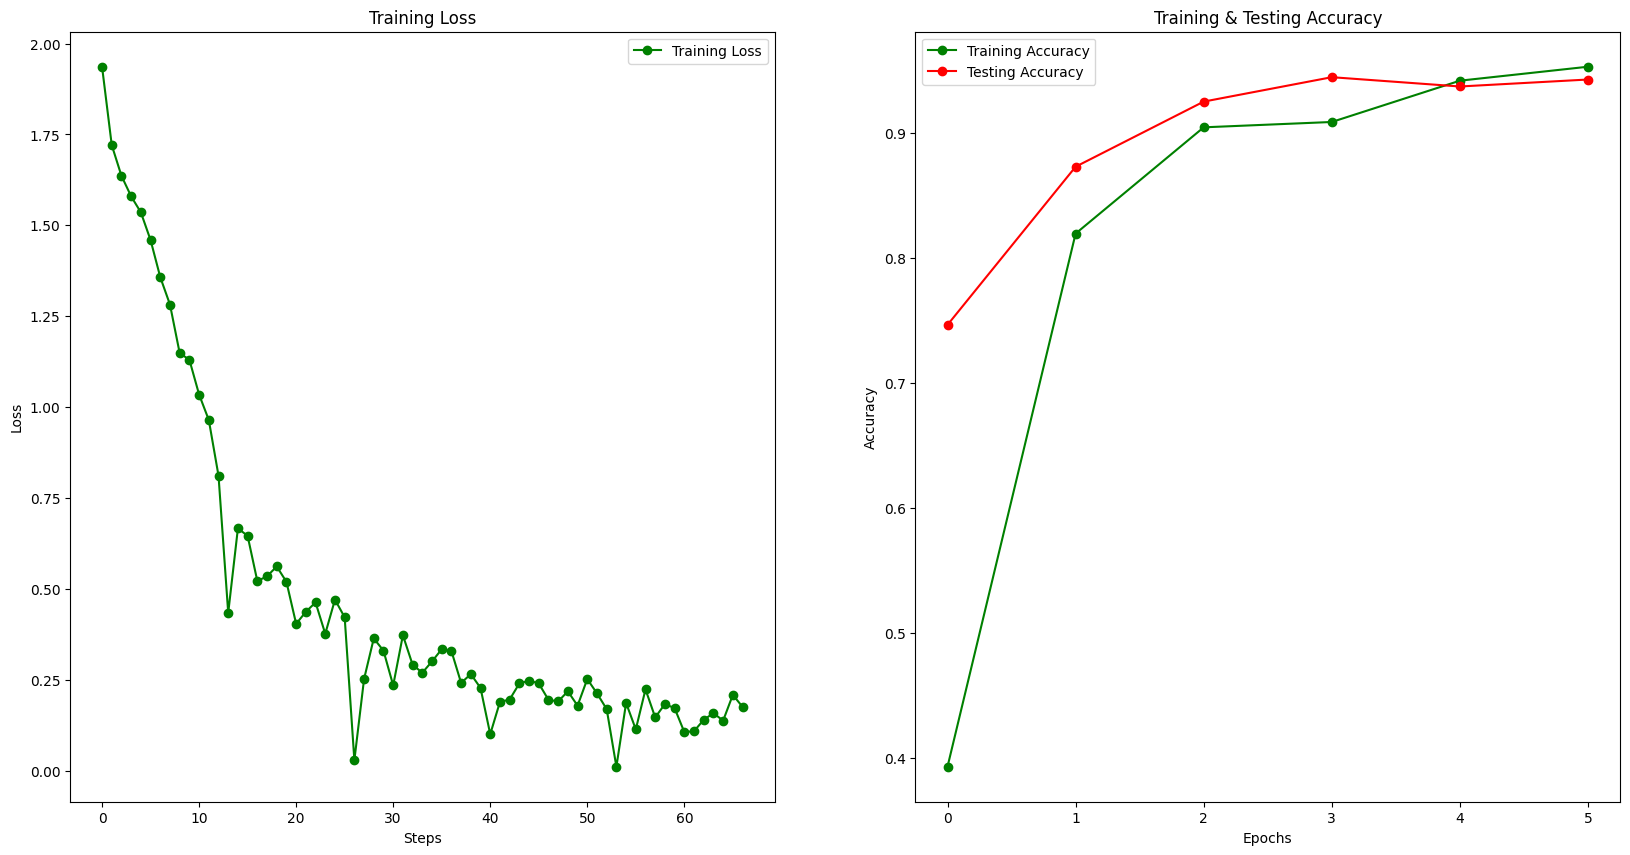

train accs:  [0.393125, 0.8192307692307693, 0.9041666666666667, 0.9084375, 0.9414473684210526, 0.9526041666666667]
val accs:  [0.7462825278810409, 0.8726765799256505, 0.9247211895910781, 0.9442379182156133, 0.9368029739776951, 0.9423791821561338]


In [16]:
# bert 5 epoch dropout
print_fig()

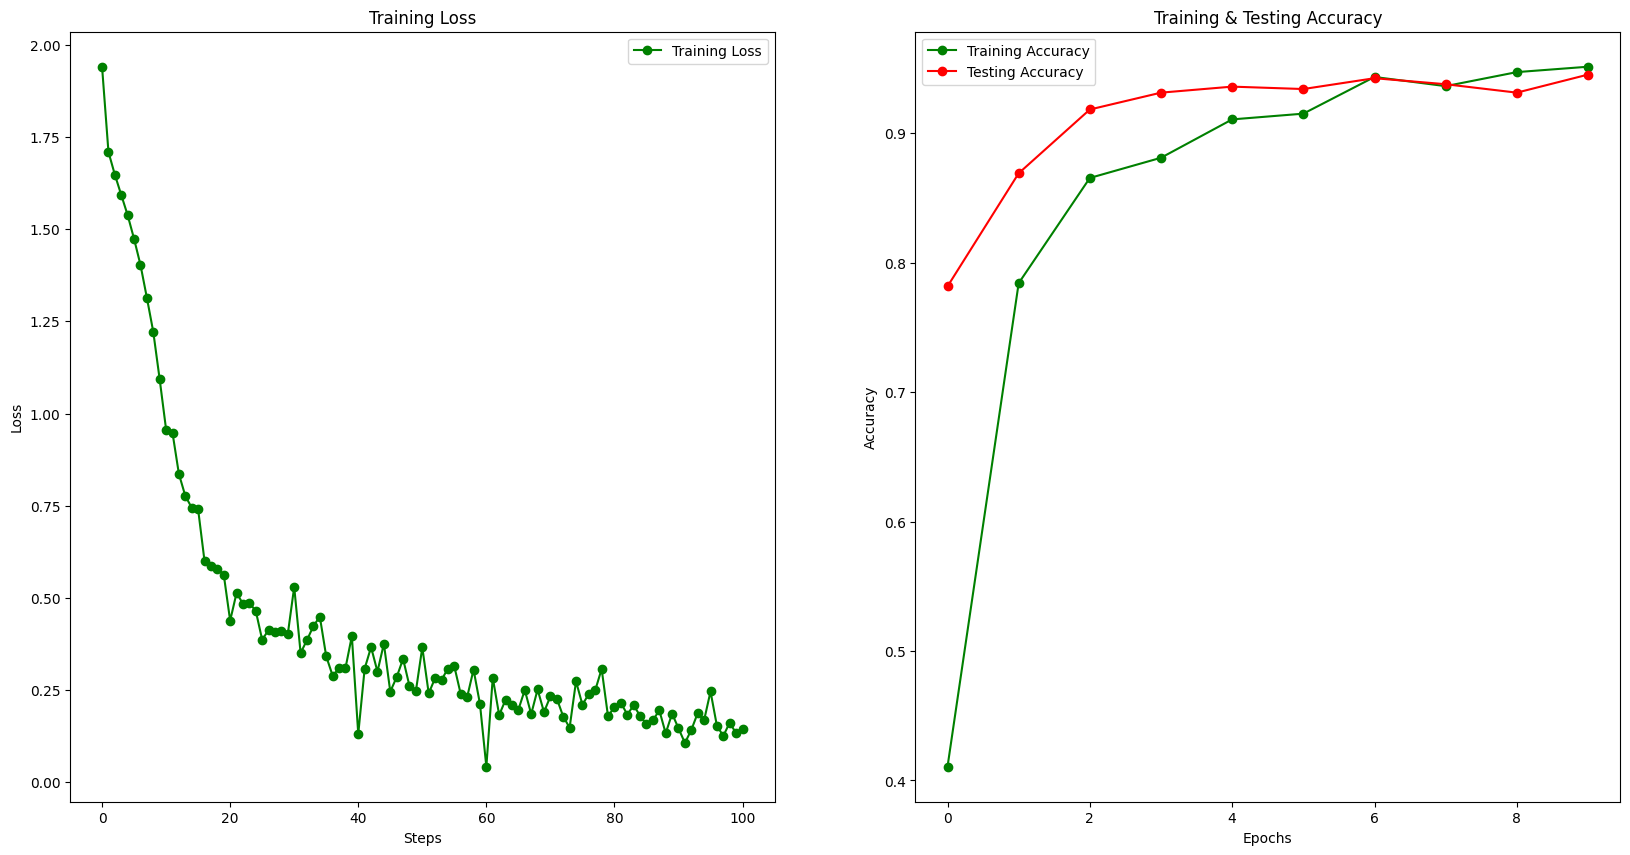

train accs:  [0.410625, 0.7840625, 0.8653350515463918, 0.8809375, 0.9105718085106382, 0.915, 0.9433379120879122, 0.93625, 0.9470880681818182, 0.95125]
val accs:  [0.7815985130111524, 0.8689591078066914, 0.9182156133828996, 0.9312267657992565, 0.9358736059479553, 0.9340148698884758, 0.9423791821561338, 0.9377323420074349, 0.9312267657992565, 0.9451672862453531]


In [151]:
# bert 5 epoch dropout
print_fig()

In [17]:
# bert 5 epoch dropout 
# no augment
predict_test_set()

test accuracies =  0.974


In [152]:
# bert 5 epoch dropout
# augment
predict_test_set()

test accuracies =  0.97


In [18]:
model.save_pretrained("./saved_model/model_bert/")